## Generate sequences

In [75]:
import itertools
import copy
import collections
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn

In [2]:
convert_inputcue = {'A':1, 'B':2, 'C':3,'D':4}
convert_operation = {'+':9, '*':10}

#inputcue_dict = {'A':0.1, 'B':12, 'C':3.3,'D':7}

def generate_trials(operators, input_ids, len_seq, init_values, replacement=False):
    ''' TODO:: Change !!
    This function defines all possible permutations of init state & sequence
    of binary input cues and operators.
    Output is an array of shape n X len_seq+1.
    Each row is one of n unique ordered permutations.
    First column indicates the initital state (binary) at t=0.
    Every following column contains a tuple, where the first position indicates
    the binary input cue and the second position indicates the operator identity
    The first element'''
    seq = []
    if replacement:
        combi_inputcue = list(itertools.product(input_ids, repeat=len_seq))
        combi_operators = list(itertools.product(operators, repeat=len_seq))
    else:
        if len_seq == 2: # if seq of 2 sample binary cue evenly
            combi_inputcue = list(itertools.permutations(input_ids, len_seq))
        else:
            combi_inputcue = list(itertools.product(input_ids, repeat=len_seq))
        combi_operators = list(itertools.permutations(operators, len_seq))

    for init in init_values:
        for cue in combi_inputcue:
            for op in combi_operators:
                #seq.append([(init, np.nan, np.nan),
                seq.append([init,
                            *zip(tuple(op), cue)]) #group per time point t

    return seq

def operate_op(currval, step_tuple, cue_dict):
    """   """
    nextval = cue_dict[step_tuple[1]]
    if step_tuple[0] == '+': # add
        currval = currval + nextval
    elif step_tuple[0] == '*': # multiply
        currval = currval * nextval
    return currval

def calculate_output(step_tuple, cue_dict):
    """ """
    curr_val = step_tuple[0]
    for i in range(1,len(step_tuple)):
        curr_val = operate_op(curr_val, step_tuple[i], cue_dict)
    return curr_val


def generate_sequences(operators, input_ids, len_seq, init_values, cue_dict, replacement=False):
    """ """
    all_trials = generate_trials(operators, input_ids, len_seq, init_values, replacement)
    for trial in all_trials:
        trial_output = calculate_output(trial, cue_dict)
        trial.append(trial_output)
    
    return(all_trials)


def convert_seq2onehot(seq, num_classes=13):
    """
    """
    data = []
    for trial in seq:
        trial_data = []
        for i,t in enumerate(trial):
            #print('t:  ', t, '\n')
            if i==0:
                init = torch.zeros(num_classes)
                init[0] = t
                trial_data.append(init)
                continue
            else:
                op = torch.tensor(convert_operation[t[0]])
                op = torch.nn.functional.one_hot(op, num_classes=num_classes)
                #print('op:  ', op)
                trial_data.append(op)

                inputcue = torch.tensor(convert_inputcue[t[1]])
                inputcue = torch.nn.functional.one_hot(inputcue, num_classes=num_classes)
                trial_data.append(inputcue)
                #print('input:  ', inputcue)
                #print('trial_data',trial_data, '\n')
        data.append(torch.stack(trial_data))
        
    data = torch.stack(data,dim=0) #combine into tensor of shape n_trials X n_time_steps X inputvector_size
    data = data.numpy()
    
    return data

class SequenceData(Dataset):
    def __init__(self, data, labels, seq_len):
        'Initialization'
        self.data = convert_seq2onehot(data)
        self.seq_len = seq_len
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sequence = self.data[index,:].astype(np.float32)
        out_state = np.array(self.labels[index]).astype(np.float32)
        return sequence, out_state
    
def convert_seq2inputs(sequences, num_classes=13, seq_len=5):
    '''
    converts sequences as they are generated by generate_experiment_lists.py
    into input to be fed into RNN (one-hote encoded)
    Parameters:
    sequences (list of lists) - list of sequences, each list contains [[state][rule,input]*[out]]*
    n_rules - number of rules that occur throughout all sequences
    ''' 
    seq = [sublist[:-1] for sublist in sequences]
    out = [sublist[-1] for sublist in sequences]
    
    seqdata = SequenceData(seq, out, seq_len)
    ### Create train-test split ###
#     train_set_size = int(len(seqdata) * 0.8)
#     test_set_size = len(seqdata) - train_set_size
#     trainset, testset = random_split(seqdata, [train_set_size, test_set_size])
    
    return seqdata

In [136]:
def convert_seq2onehot2(seq, num_classes=13):
    """
    """
    data = []
    for trial in seq:
        trial_data = []
        for i,t in enumerate(trial):
            #print('t:  ', t, '\n')
            if i==0:
                init = torch.zeros(num_classes)
                init[0] = t
                trial_data.append(init)
                continue
            else:
                op = torch.tensor(convert_operation[t[0]])
                op = torch.nn.functional.one_hot(op, num_classes=num_classes)

                inputcue = torch.tensor(convert_inputcue[t[1]])
                inputcue = torch.nn.functional.one_hot(inputcue, num_classes=num_classes)
                op_cue = op + inputcue
                trial_data.append(op_cue)
        data.append(torch.stack(trial_data))
        
    data = torch.stack(data,dim=0) #combine into tensor of shape n_trials X n_time_steps X inputvector_size
    data = data.numpy()
    
    return data


class SequenceData2(Dataset):
    def __init__(self, data, labels, seq_len):
        'Initialization'
        self.data = convert_seq2onehot2(data)
        self.seq_len = seq_len
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sequence = self.data[index,:].astype(np.float32)
        out_state = np.array(self.labels[index]).astype(np.float32)
        return sequence, out_state
    

def convert_seq2inputs2(sequences, num_classes=13, seq_len=5):
    '''
    converts sequences as they are generated by generate_experiment_lists.py
    into input to be fed into RNN (one-hote encoded)
    Parameters:
    sequences (list of lists) - list of sequences, each list contains [[state][rule,input]*[out]]*
    n_rules - number of rules that occur throughout all sequences
    ''' 
    seq = [sublist[:-1] for sublist in sequences]
    out = [sublist[-1] for sublist in sequences]
    
    seqdata = SequenceData2(seq, out, seq_len)
    ### Create train-test split ###
#     train_set_size = int(len(seqdata) * 0.8)
#     test_set_size = len(seqdata) - train_set_size
#     trainset, testset = random_split(seqdata, [train_set_size, test_set_size])
    
    return seqdata

# Data generation

In [122]:
cue_dict = {'A': 2, 
            'B': 3,
            'C': 5,
            'D': 7}

operators = ['+', '*']
input_ids = ['A', 'B', 'C', 'D'] 

len_seq = 2
init_values = np.arange(1,7, 2)#.round(1)
seq = generate_sequences(operators, input_ids, len_seq, init_values, cue_dict)
seqs = convert_seq2inputs(seq, num_classes=13, seq_len=5)
train_data = DataLoader(seqs, batch_size=1, shuffle=True)

outs = np.array([ s[-1] for s in seq])
print('no. combos: ', len(outs))
print('unique combos: ', len(np.unique(outs)))

no. combos:  72
unique combos:  35


In [137]:
seqs2 = convert_seq2inputs2(seq, num_classes=13, seq_len=5)
train_data2 = DataLoader(seqs2, batch_size=1, shuffle=True)

## RNN architecture

In [149]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]


def train(sequence,label,model,optimizer,criterion):

    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    for i in range(len(sequence[0])):
        output, hidden = model.forward(sequence[0][i], hidden)
    #Compare final output to target
    loss = criterion(output,label)#.long())
    #Back-propagate
    loss.backward()
    optimizer.step()

    return output, loss.item()

def run(model, train_data, epochs):

    model.train()
    loss_history = []
    for epoch in range(epochs):
        lossTotal = []
        for x,y in train_data:
            output, loss = train(x,y,model,optimizer,criterion)
            #lossTotal.append(loss)
            lossTotal.append(loss/y.item())
        rmse = np.mean(lossTotal)
        loss_history.append(rmse)
        
        ### TODO: better CV(RMSE) = RMSE/mean

    print(f'Fractional RMSE: {round(rmse*100, 1)} %')
    return loss_history


In [133]:
num_classes = 13
input_size = num_classes
output_size = 1
hidden_size = 20
num_layers = 1
epochs = 250
learningRate = 0.005


In [166]:
num_sims = 20

## example
losses = []
for j in range(num_sims):
    print('### rep', j, ' ###')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss = run(model, train_data2, epochs)
    losses.append(loss)

### rep 0  ###
Fractional RMSE: 1.1 %
### rep 1  ###
Fractional RMSE: 2.7 %
### rep 2  ###
Fractional RMSE: 5.7 %
### rep 3  ###
Fractional RMSE: 4.0 %
### rep 4  ###
Fractional RMSE: 4.7 %
### rep 5  ###
Fractional RMSE: 5.4 %
### rep 6  ###
Fractional RMSE: 3.6 %
### rep 7  ###
Fractional RMSE: 2.3 %
### rep 8  ###
Fractional RMSE: 2.9 %
### rep 9  ###
Fractional RMSE: 1.2 %
### rep 10  ###
Fractional RMSE: 1.9 %
### rep 11  ###
Fractional RMSE: 5.9 %
### rep 12  ###
Fractional RMSE: 6.8 %
### rep 13  ###
Fractional RMSE: 7.4 %
### rep 14  ###
Fractional RMSE: 2.8 %
### rep 15  ###
Fractional RMSE: 13.2 %
### rep 16  ###
Fractional RMSE: 1.2 %
### rep 17  ###
Fractional RMSE: 2.3 %
### rep 18  ###
Fractional RMSE: 2.6 %
### rep 19  ###
Fractional RMSE: 1.1 %


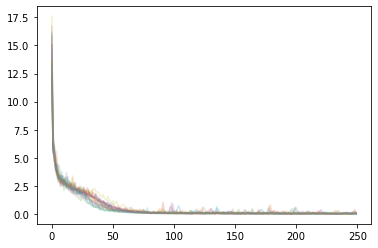

In [167]:
for los in losses:
    plt.plot(los, alpha=0.2)

In [168]:
lls = [lo[-1] for lo in losses]
np.mean(lls)*100

3.936194050067275

In [165]:
len(lls)

20

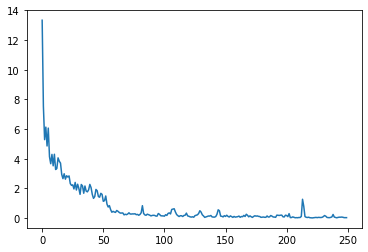

In [132]:
plt.plot(loss)

In [83]:
# epochs = 500
## lr = 0.005 - RMSE 159.2102045240118
## lr = 0.01 -  170.10873604980821
# lr = 0.001 - 1628.6553391298223

In [692]:
torch.zeros(1, model.hidden_size)[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [672]:
rnn = OneStepRNN(input_size, output_size, hidden_size, num_layers)
hidden = rnn.initHidden()
x = torch.tensor(train.data[3])

In [673]:
y

array(5., dtype=float32)

In [604]:
x,y = train[3]
x = torch.tensor(x[0]).reshape(1,-1)

In [605]:
hidden = torch.zeros(1, hidden_size)

In [606]:
print('hidden size:   ', hidden.size())
print('input size:   ', x.size())

hidden size:    torch.Size([1, 20])
input size:    torch.Size([1, 13])


## Example

no. combos:  72
unique combos:  66


In [90]:
len(seqs)

72

In [731]:
for x, y in tt:
    print(x)

tensor([[[5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
tensor([[[5.9000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])
tensor([[[3.8000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [467]:
t1 = torch.tensor(train[1][0])

In [469]:
t2 = torch.zeros(5,20)

In [485]:
torch.cat((t1, t2), 1).size()

torch.Size([5, 33])

In [525]:
tt

TypeError: 'DataLoader' object is not subscriptable